# **Group 37: DSCI 100**
# **Physical Characteristics of Tennis Players Influencing their Likelihood of Winning Matches**

----------------------------------------------------------


## Research question: do tennis players' physical characteristics influence their likelihood of winning a game?

--------------------

## Introduction
Our project aims to identify the likelihood of winning (or losing) tennis matches in the ATP tournament based on a player’s physical characteristics such as height and age. We hypothesise that these factors will have a significant effect on match outcomes, as some other physical characteristics, such as anaerobic capabilities, bone length and bone strength are already shown to have a positive effect on match outcomes. This is for studies in tennis and other sports as well (_see_ Khasawneh, 2015; Davis _et al._, 2004; Meckel _et al._, 2015). Our dataset is taken from a database which compiles ATP tournament match data from 2020, a link to which is provided on the Canvas group project page (Sackmann, 2020). The ATP Tour is a global top-level male tennis tour organised by the Association of Tennis Professionals (ATP). 

While our dataset contains 49 columns and almost 1500 rows, we are whittling this down to focus on exclusively physical characteristic data of players. We have also created a new binary variable, `win_lose`, which indicates the overall result of a tennis match. Our project will focus on a $K$-nearest neighbours classification analysis of our two classifier variables and our one predictor variable. We will try to predict the outcome of a match based on players' age and height. We are using a $K$-nn classification algorithm instead of a regression (for instance) because we are predicting a _categorical variable_.



In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RCurl)
library(cowplot)
options(repr.matrix.max.rows = 6)
set.seed(1) #setting the seed here and throughout the analysis to ensure reproducability

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#reading the dataset into Jupyter
x <- getURL("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2020.csv")
match_data <- read.csv(text = x)

In [3]:
#Table 1.1
match_data

tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2020-8888,Atp Cup,Hard,24,A,20200106,300,104925,NA,,⋯,51,39,6,10,6,8,2,9055,1,9985
2020-8888,Atp Cup,Hard,24,A,20200106,299,105138,NA,,⋯,35,21,6,9,5,10,10,2335,34,1251
2020-8888,Atp Cup,Hard,24,A,20200106,298,104925,NA,,⋯,57,35,25,14,6,11,2,9055,5,5705
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2020-7485,Antwerp,Hard,32,A,20201019,128,126203,7,,⋯,37,30,5,9,3,5,28,1670,33,1402
2020-7485,Antwerp,Hard,32,A,20201019,129,144750,NA,Q,⋯,45,29,5,10,7,11,90,748,74,838
2020-7485,Antwerp,Hard,32,A,20201019,130,200005,NA,,⋯,32,26,7,9,2,4,38,1306,172,353


 _**Table 1.1**_

We will first split the `match_data` into two tables based on whether a player won or lost their match. 

Then we will add a variable indicating if it is a win or loss and we will select for the variables of interest which are `height`, `age` and `match_result`. 

This is because we are focusing on investigating how the physical characteristics of tennis players influence their likelihood of winning.
After, we will rename the columns `height` and `age` to remove redundancy and improve consistency. We will put the two tables of `win` and `lose` into one data frame for later use. 

In [4]:
match_data_winner <- match_data |> 
                    mutate(match_result = "win") |>
                    select(winner_ht, winner_age, match_result) |>
                    rename(ht = winner_ht, age = winner_age)

match_data_loser <- match_data |> 
                    mutate(match_result = "lose") |>
                    select(loser_ht, loser_age, match_result) |>
                    rename(ht = loser_ht, age = loser_age)

match_data_tidy <- bind_rows(match_data_winner, match_data_loser)

In [5]:
#Table 1.2 This is the dataframe we are going to split into training and testing models to predict the match result.
match_data_tidy

ht,age,match_result
<int>,<dbl>,<chr>
188,32.6,win
183,31.7,win
188,32.6,win
⋮,⋮,⋮
211,23.1,lose
178,21.5,lose
180,26.6,lose


_**Table 1.2**_

In [6]:
set.seed(1) #setting the seed to ensure reproducability
match_split <- initial_split(match_data_tidy, prop = 0.75, strata = match_result)

# training set
match_train <- training(match_split)

# testing set
match_test <- testing(match_split)

Here, we separated the data into training (`match_train`) and testing (`match_test`) sets, with a training/testing split of 75/25% based on the match result (`match_result`)

In [7]:
#Check number of missing values in each column of the table ONLY USING TRAINING DATA
num_na <- match_train |> 
            summarize_all(~sum(is.na(.))) 

In [8]:
#Table 1.3 There are 36 missing values in the height column.
num_na

ht,age,match_result
<int>,<int>,<int>
36,0,0


_**Table 1.3**_

In [9]:
#remove NA tuples from datasets
match_train <- filter(match_train, !is.na(ht))
match_test <- filter(match_test, !is.na(ht))

**NOTE**: 
Of the 2934 tuples in our dataset, 36 of them have an NA value in one of the variables of interest. Thats only slightly more than 1% of the data, so the dataset is still suitable for analysis.

In [10]:
#Histograms of the height and age variable distributions ONLY USING TRAINING DATA
options(repr.plot.width = 13, repr.plot.height =8)
prelim_hist_height <- ggplot(data = match_train, aes(x = ht))+
                geom_histogram(binwidth = 5, color = "black", fill = "white")+
                labs(x = "Height (cm)", y = "Count")+
                ggtitle("Distribution of Height")+
                theme(text = element_text(size = 15))

prelim_hist_age <- ggplot(data = match_train, aes(x = age))+
                geom_histogram(binwidth = 2, color = "black", fill = "white")+
                labs(x = "Age (years)", y = "Count")+
                ggtitle("Distribution of Age")+
                theme(text = element_text(size = 15))

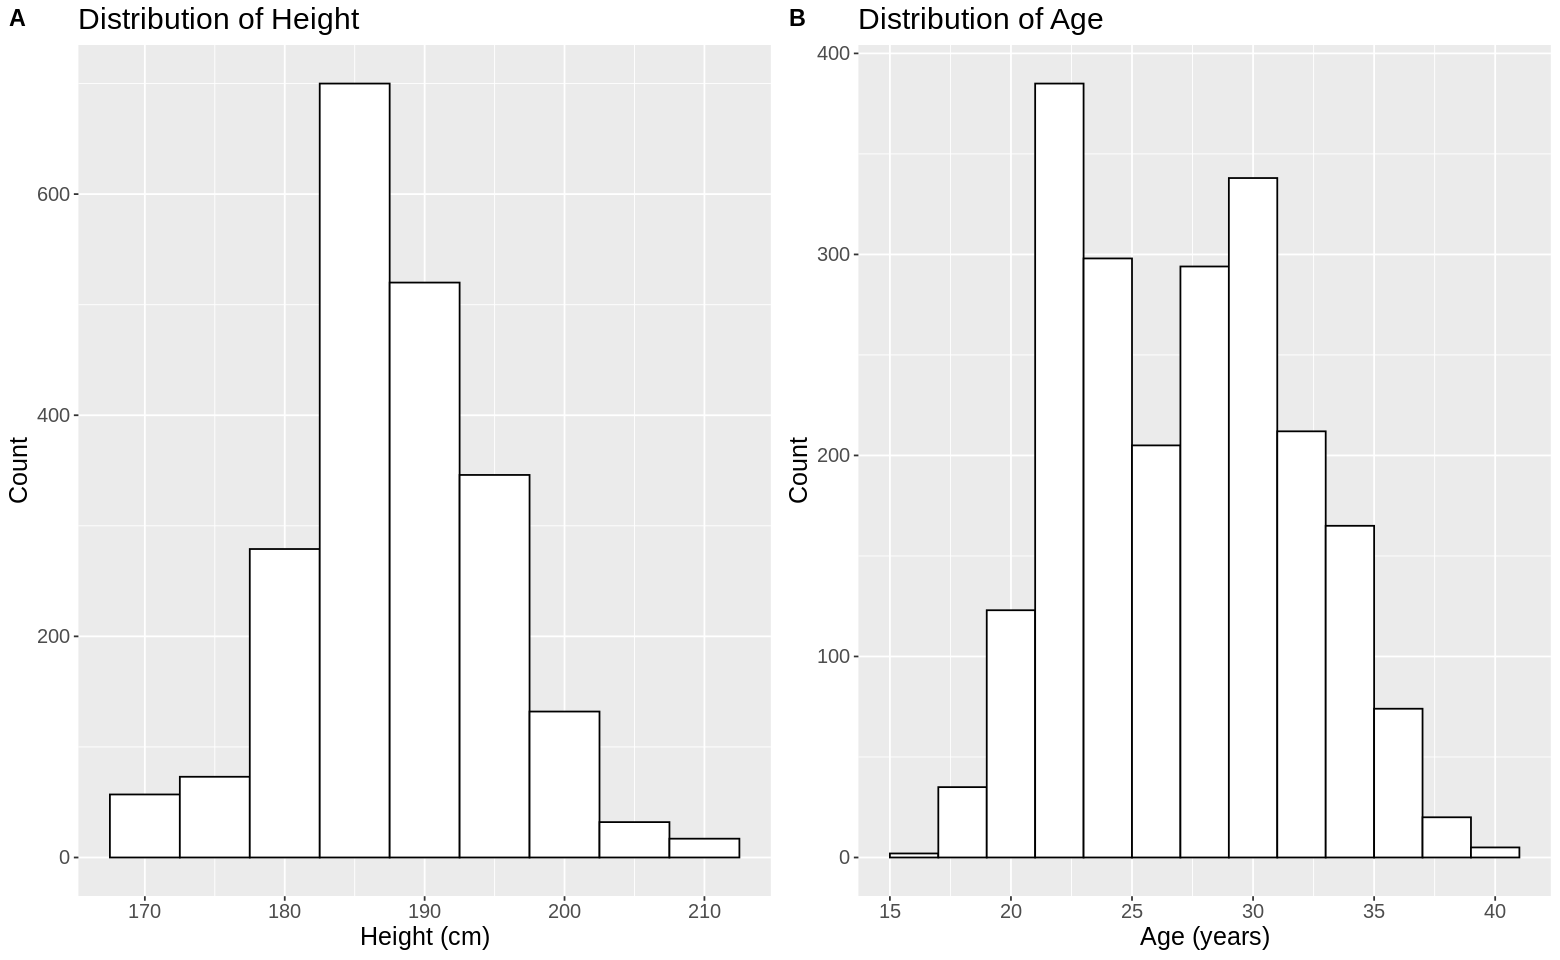

In [11]:
# Figure 1.1 To look at the distribution of height and age of tennis players in training set
plot_grid(prelim_hist_height, prelim_hist_age, labels = "AUTO")

_**Figure 1.1**_ - Players' distribution of height and age out of all tennis players (training dataset)

In [12]:
match_proportions <- match_train |>
                      group_by(match_result) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(match_train))

This step is to check the percentage of winning and losing in the data set to make sure one does not outweigh the other

In [13]:
#Table 1.4 - lose/win split in training data.
match_proportions 

match_result,n,percent
<chr>,<int>,<dbl>
lose,1068,49.53618
win,1088,50.46382


_**Table 1.4 - initial split of lose/win in training dataset**_

There is roughly 49.5% of losing data in the training dataset and 50.5% of winning data. 

In [14]:
# Change datatype of match_result from character to factor in order for the next few functions to work 
# and successfully classify if it's a win or lose
match_train$match_result <- as.factor(match_train$match_result)
match_test$match_result <- as.factor(match_test$match_result)

In [15]:
#setup standard recipe, setup knn_spec to tune for the best k value

match_recipe <- recipe(match_result ~ ht + age, data = match_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [16]:
#trying 10 different k values, count by every 3 from 1 to 30
set.seed(1)
k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 3))

match_vfold <- vfold_cv(match_train, v = 5, strata = match_result)

knn_results <- workflow() |>
  add_recipe(match_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = match_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

In [17]:
#Table 1.5 This is the accuracy table for each k value from 1 to 30 counting by 3
accuracies |>  arrange(desc(mean))

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
10,accuracy,binary,0.5287511,5,0.009752368,Preprocessor1_Model04
13,accuracy,binary,0.5250560,5,0.006741535,Preprocessor1_Model05
7,accuracy,binary,0.5204113,5,0.004370763,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
25,accuracy,binary,0.4986176,5,0.006734890,Preprocessor1_Model09
4,accuracy,binary,0.4893389,5,0.008169541,Preprocessor1_Model02
1,accuracy,binary,0.4893239,5,0.004122565,Preprocessor1_Model01


_**Table 1.5**_

In [18]:
#plotting accuracies of different k, best seems to be 10
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 15))

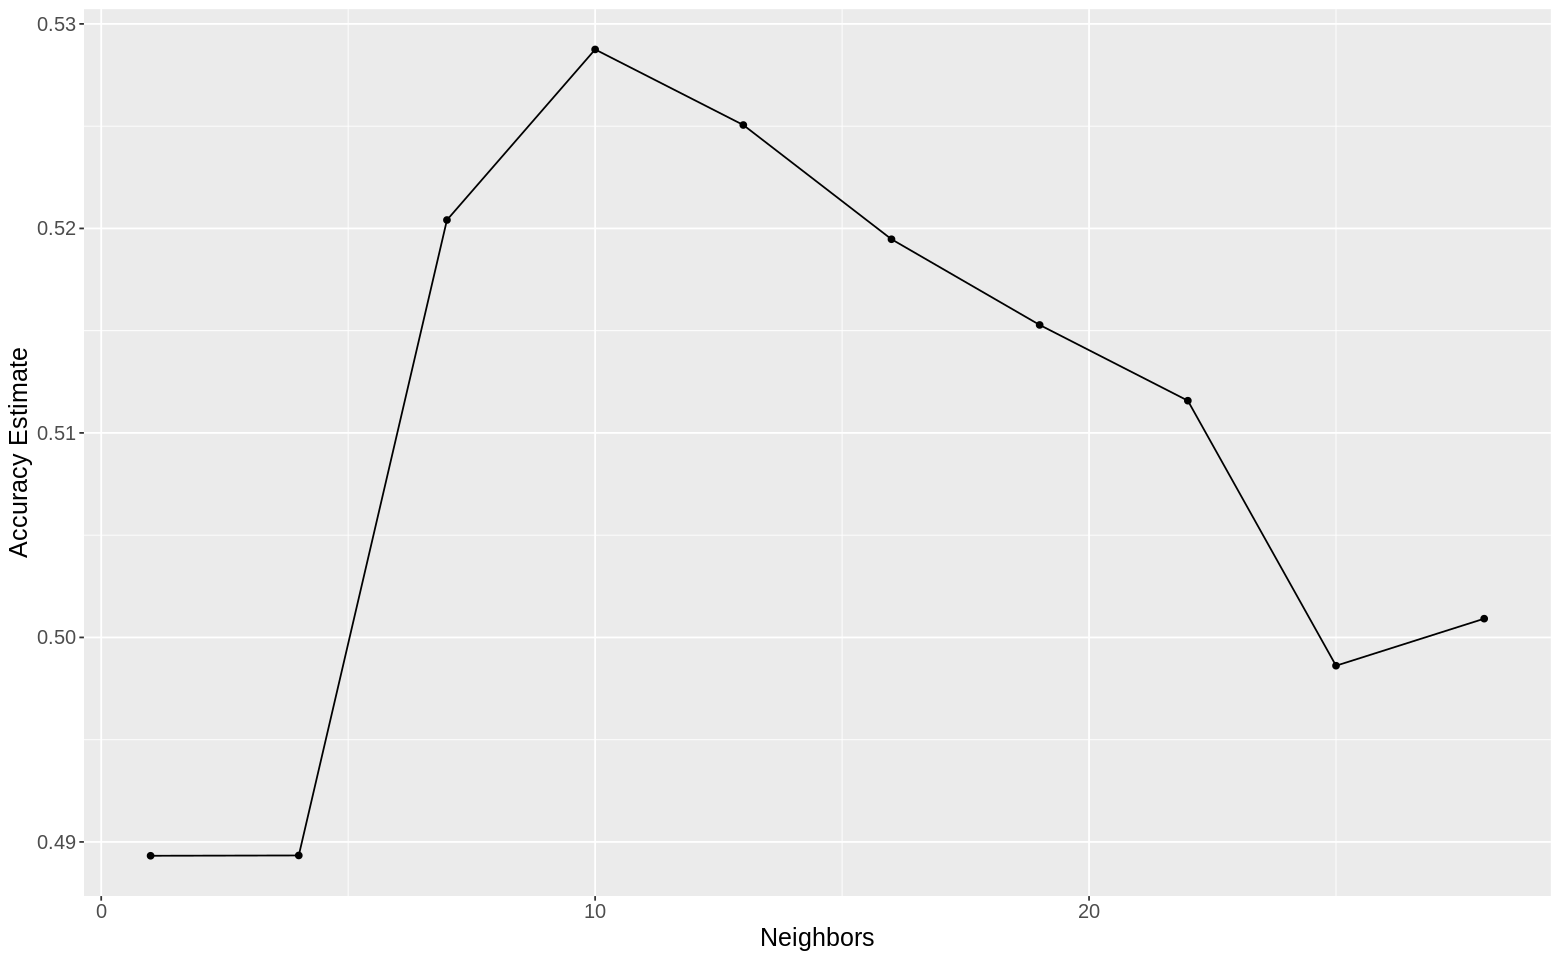

In [19]:
#Figure 1.2
accuracy_vs_k 

_**Figure 1.2**_ - This is the graph with k values on the x-axis and its _estimated_ accuracy on the y-axis. The highest accuracy is when $K$ is 10 with an accuracy of 53% roughly, and this is therefore the best $K$-value to choose.

In [20]:
#display accuracy of model using best k and cross-validation 

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(match_recipe) |>
  add_model(knn_spec) |>
  fit_resamples(resamples = match_vfold)

accuracy_value <- knn_fit |> 
  collect_metrics() 

In [21]:
#Table 1.6 The table shows our model has an accuracy of 53%.
accuracy_value

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.5287511,5,0.009752368,Preprocessor1_Model1
roc_auc,binary,0.5455527,5,0.011857998,Preprocessor1_Model1


_**Table 1.6**_ - This shows our `vfold`-trained model has an accuracy of 53%. Later, however, when we evaluate our model on previously unseen (testing) data, we will see the model's true accuracy increase to 55.2%.

In [22]:
#test predictions using test-data
set.seed(1)
knn_fit <- workflow() |>
  add_recipe(match_recipe) |>
  add_model(knn_spec) |>
  fit(match_train)

match_test_predictions <- predict(knn_fit, match_test) |>
  bind_cols(match_test)

accuracy_only <- match_test_predictions |>
  metrics(truth = match_result, estimate = .pred_class) |>
  filter(.metric == "accuracy")


confusion <- match_test_predictions |>
             conf_mat(truth = match_result, estimate = .pred_class)

In [23]:
#Table 1.7 The table shows a 55.2% accuracy on how accurate our model predicts our test data
accuracy_only

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5520111


For a predictive model, this is only marginally superior to chance (50%), and hence this is a very poor predictive model. We can preliminarily note that for our dataset, the physical characteristics available to us (`age` and `height`) of players do not have a significant effect on match outcomes (`match_result`).

In [24]:
#Table 1.8 It shows the prediction of our model
match_test_predictions

.pred_class,ht,age,match_result
<fct>,<int>,<dbl>,<fct>
win,183,31.7,win
lose,180,29.0,win
lose,188,32.6,win
⋮,⋮,⋮,⋮
lose,181,31.2,lose
lose,185,27.8,lose
lose,188,32.7,lose


_**Table 1.8**_

In [25]:
#Table 1.9
confusion

          Truth
Prediction lose win
      lose  230 195
      win   128 168

The confusion matrix shows a summary of the predictions. It predicts 230 losing data to be losing and 195 winning data to be losing. It predicts 128 losing data to be winning and 168 winning data to be winning and overall has an accuracy of 55.2%.

_**Table 1.9**_

In [26]:
#creating a new column to determine how accurate our predictions are and 
# graph plotting predictions vs real values

prediction_accuracy <- match_test_predictions |>
    mutate(predict_accuracy = .pred_class == match_result)

prediction_plot <- ggplot(data = match_test_predictions, aes(x = ht, y = age, color = match_result, shape = .pred_class)) +
                        geom_point(size = 3) + 
                        labs(x = "Height (cm)", y = "Age (years)")

prediction_plot2 <- ggplot(data = prediction_accuracy,aes(x = ht, y = age, color = predict_accuracy)) +
                        geom_point(size = 3) + 
                        labs(x = "Height (cm)", y = "Age (years)")

In [27]:
#Table 2.0 It shows the prediction's accuracy by saying it's true or false
prediction_accuracy

.pred_class,ht,age,match_result,predict_accuracy
<fct>,<int>,<dbl>,<fct>,<lgl>
win,183,31.7,win,TRUE
lose,180,29.0,win,FALSE
lose,188,32.6,win,FALSE
⋮,⋮,⋮,⋮,⋮
lose,181,31.2,lose,TRUE
lose,185,27.8,lose,TRUE
lose,188,32.7,lose,TRUE


_**Table 2.0**_

In [28]:
#creating a new column to determine how accurate our predictions are
prediction_accuracy <- match_test_predictions |>
    mutate(predict_accuracy = .pred_class == match_result)

#to visualize the prediction accuracy
prediction_accuracy_plot <- ggplot(data = prediction_accuracy,aes(x= ht, y= age, fill = predict_accuracy)) +
                                geom_bar(stat = "identity") + 
                                labs(x = "Height (cm)", y = "counts", fill = "Predictor Accuracy (True or False)") + 
                                theme(text = element_text(size = 15))

#to list out accurate and false predictions and expected outcomes
predict_accurate <- prediction_accuracy |> 
    count(.pred_class, match_result) |>
    mutate(predict_accuracy = .pred_class == match_result)

#to visualize the total number of true and false predictions
predict_accurate_plot <- ggplot(predict_accurate, aes(x= predict_accuracy, y=n)) +
                            geom_bar(stat = "identity") + 
                            labs(x = "Prediction Accuracy (true or false)", y = "Count") + 
                            theme(text = element_text(size = 20))

#total number of predicted win and lose
pred_class_data <- prediction_accuracy |>
    count(.pred_class)

#actual total number of win and lose
match_result_data <- prediction_accuracy |>
    count(match_result)

#to visualize the count of predicted win and lose
pred_class_plot <- ggplot(pred_class_data, aes(x= .pred_class, y= n)) +
                        geom_bar(stat = "identity") + 
                        labs(x = "Prediction (win or lose)", y = "Count") + 
                        theme(text = element_text(size = 15))

#to visualize the actual count of win and lose
match_result_plot <- ggplot(match_result_data, aes(x= match_result, y= n)) +
                        geom_bar(stat = "identity") + 
                        labs(x = "Actual Result (win or lose)", y = "Count") + 
                        theme(text = element_text(size = 15))

In [29]:
#Table 2.0
prediction_accuracy

.pred_class,ht,age,match_result,predict_accuracy
<fct>,<int>,<dbl>,<fct>,<lgl>
win,183,31.7,win,TRUE
lose,180,29.0,win,FALSE
lose,188,32.6,win,FALSE
⋮,⋮,⋮,⋮,⋮
lose,181,31.2,lose,TRUE
lose,185,27.8,lose,TRUE
lose,188,32.7,lose,TRUE


_**Table 2.0**_

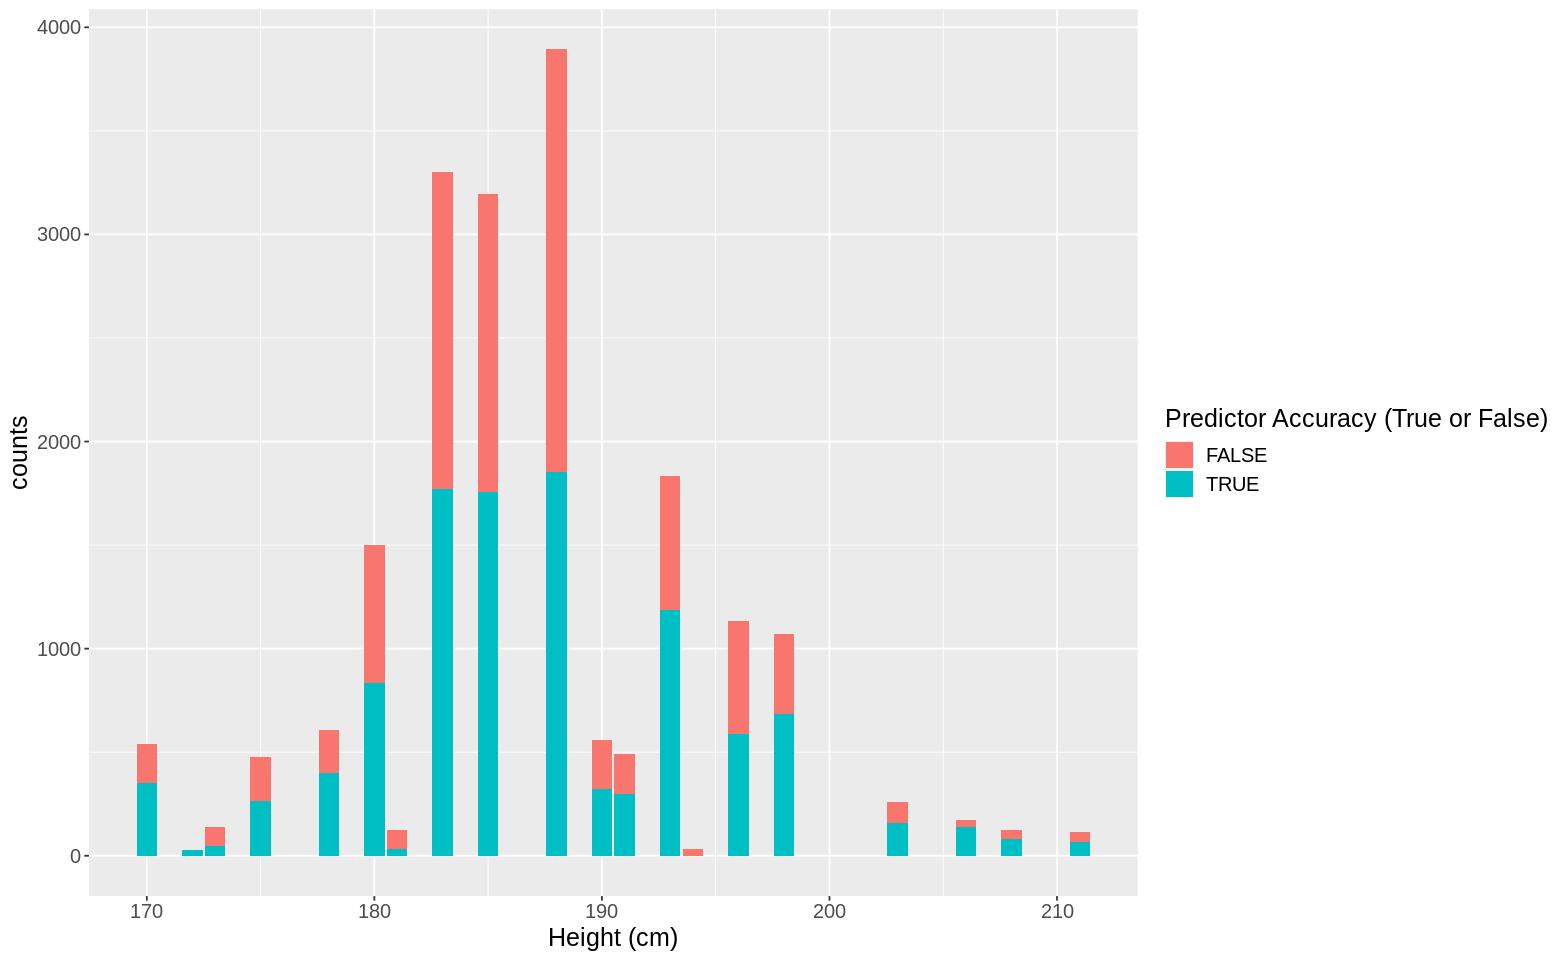

In [30]:
#Figure 1.3 
prediction_accuracy_plot

_**Figure 1.3**_ - The graph shows the distribution of predictions (erroneous or not) on the height of tennis players in our dataset

In [31]:
#Table 2.1 Shows confusion matrix in a table for later graphs
predict_accurate

.pred_class,match_result,n,predict_accuracy
<fct>,<fct>,<int>,<lgl>
lose,lose,230,TRUE
lose,win,195,FALSE
win,lose,128,FALSE
win,win,168,TRUE


_**Table 2.1**_

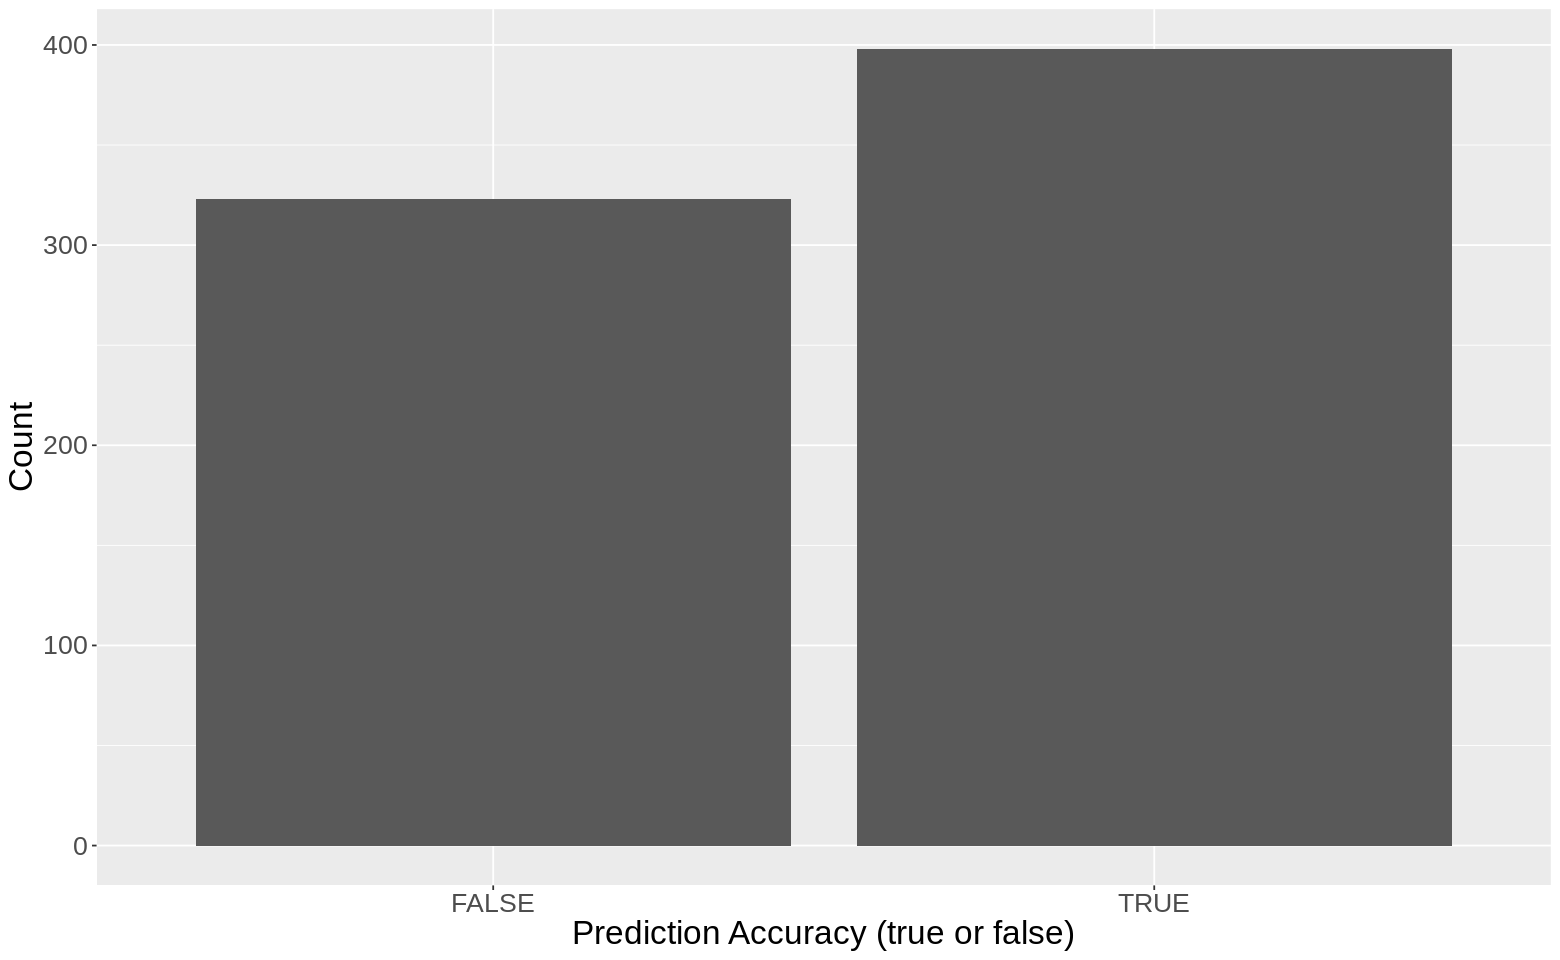

In [32]:
#Figure 1.4 To visualize the sum of model's accurate and false predictions
predict_accurate_plot 

_**Figure 1.4**_ - This graph shows the distribution of absolute `TRUE` versus `FALSE` predictions on testing data. There are more `TRUE` predictions than `FALSE` ones. However, this is not nearly enough to make the model a 'good' or 'accurate' model. 

In [33]:
#Table 2.2 Table for the sum of prediction counts only
pred_class_data

.pred_class,n
<fct>,<int>
lose,425
win,296


_**Table 2.2**_

In [34]:
#Table 2.3 Table for the sum of actual match results data counts only
match_result_data

match_result,n
<fct>,<int>
lose,358
win,363


**_Table 2.3_**

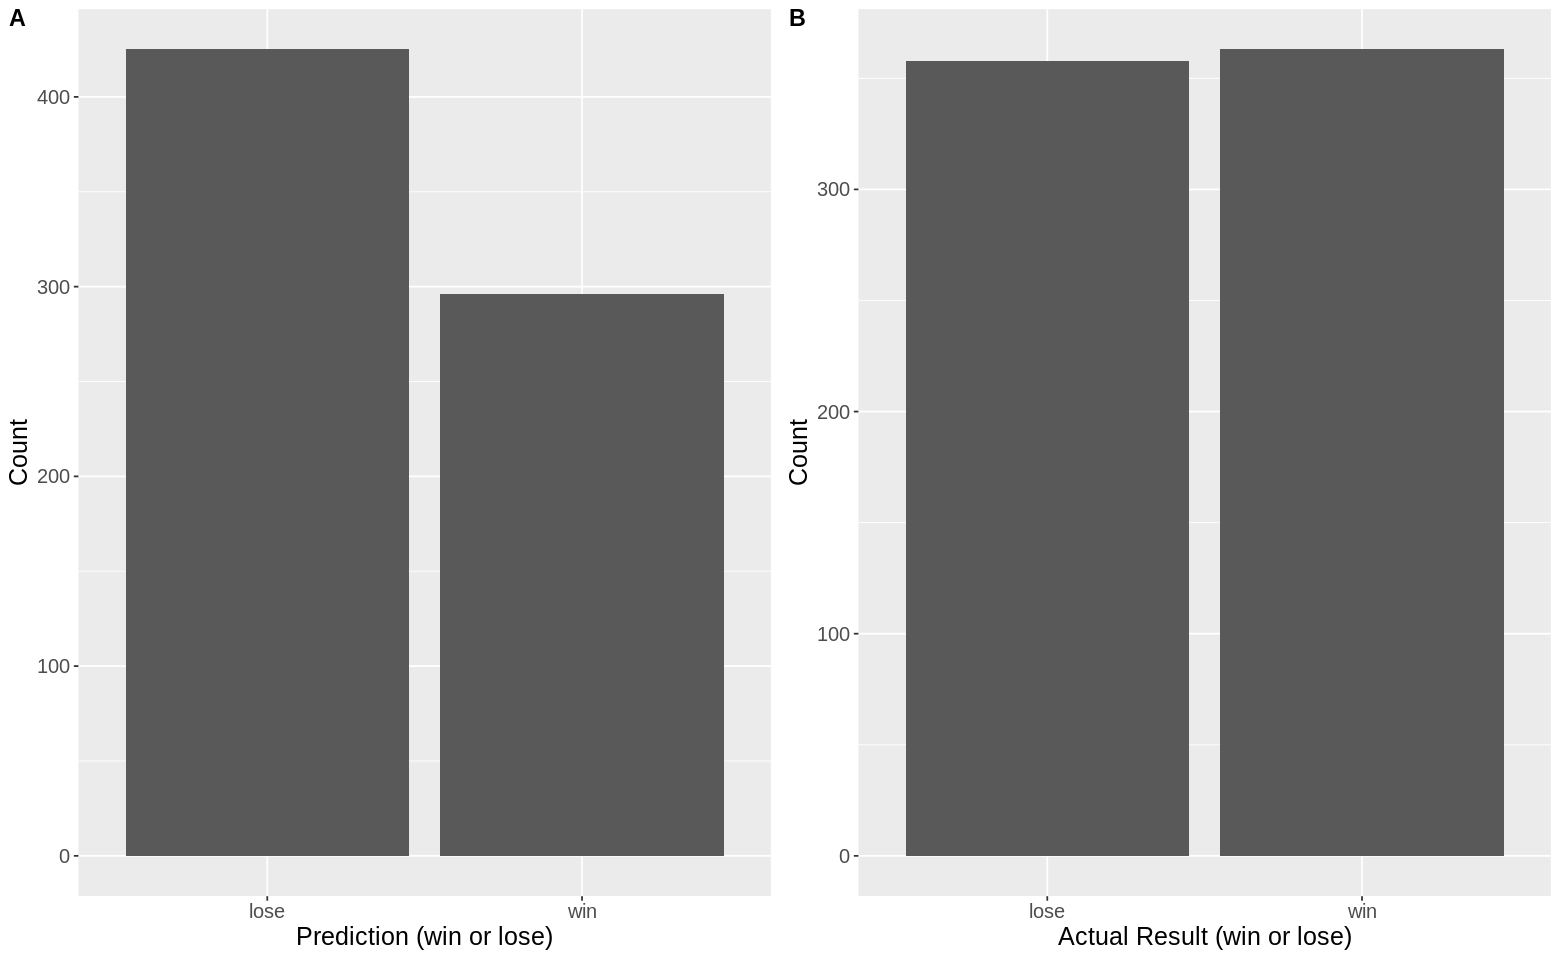

In [35]:
#Figure 1.5 To visualize the prediction results's total number of win and loss compared to the actual results of win and loss
plot_grid(pred_class_plot, match_result_plot, labels = 'AUTO')

_**Figure 1.5**_ - The proportion of predicted results (plot A) versus actual results (plot B)

-----

# Forward Selection

Below, we are performing a forward selection process to determine other potential predictors we could have used within our analysis. Since our dataset `match_data` includes few physical characteristics apart from the `age` and `height` of players (it focuses on match rather than player data _per se_), we have added all potential predictors into the forward selection algorithm. 

While this method is useful in helping us determine the accuracy of using all potential predictors in our dataset, it increases the project's processing time significantly. Up to this point, the `.ipynb` file should compute in under one minute. However, the forward selection process can stretch this up to twenty-two minutes, reducing its utility in our analysis.

In [36]:
#adding column for match result, and combining variables that are separated as "winner" and "loser" into one column
set.seed(1)
match_winner <- match_data |> 
                    mutate(match_result = "win") |>
                    select(winner_hand, winner_ht, winner_age, match_result, winner_rank, minutes, contains("w_")) |>
                    rename(hand = winner_hand, ht = winner_ht, age = winner_age, rank = winner_rank, ace = w_ace, df = w_df, svpt = w_svpt,
                           firstIn = w_1stIn, firstWon = w_1stWon, secondWon = w_2ndWon, SvGms = w_SvGms, bpSaved = w_bpSaved, bpFaced = w_bpFaced)

match_loser <- match_data |> 
                    mutate(match_result = "lose") |>
                    select(loser_hand, loser_ht, loser_age, match_result, loser_rank, minutes, contains("l_")) |>
                    rename(hand = loser_hand, ht = loser_ht, age = loser_age, rank = loser_rank, ace = l_ace, df = l_df, svpt = l_svpt,
                           firstIn = l_1stIn, firstWon = l_1stWon, secondWon = l_2ndWon, SvGms = l_SvGms, bpSaved = l_bpSaved, bpFaced = l_bpFaced)

match_tidy <- bind_rows(match_winner, match_loser)

match_tidy_l <- match_tidy |>
                filter(hand == "L") |>
                mutate(hand = 0)

match_tidy_r <- match_tidy |>
                filter(hand == "R") |>
                mutate(hand = 1)


match_tidy_hands <- bind_rows(match_tidy_l, match_tidy_r) #see Table 2.4

#loading data with all potentional predictors. 
#This increases the kernel's processing time to up to 15-20 minutes because of the large number of predictors.
match_data_subset <- match_tidy_hands |> # see table 2.5
    select(match_result, #the result of a tennis match: win or loss
           hand, #which hand the players use
           ht, #the height of a player
           age, #the age of a player
           rank, #the player's ATP rank
           minutes, #match length in minutes
           ace, #number of aces per game
           df, #number of double faults per game
           svpt, #number of serve points per game
           firstWon, #number of first-serve points won
           firstIn, #number of first serves made
           secondWon, #number of second-serve points won
           SvGms, #number of serve games
           bpSaved, #number of break points saved
           bpFaced) #number of break points faced
            |> na.omit()

names <- colnames(match_data_subset |> select(-match_result))


In [42]:
#Table 2.4 Adding the new 'hand' column and changing the hand column from character to a real number. See above!
match_tidy_hands

hand,ht,age,match_result,rank,minutes,draw_size,ace,df,svpt,firstIn,firstWon,secondWon,SvGms,bpSaved,bpFaced
<dbl>,<int>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,185,33.5,win,1,133,24,5,3,84,61,48,10,15,1,3
0,185,33.5,win,1,127,24,7,3,76,48,33,18,11,6,8
0,185,33.5,win,1,109,24,2,2,56,35,26,12,11,2,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,185,27.8,lose,79,115,NA,4,1,77,43,31,14,13,3,7
1,211,23.1,lose,33,67,NA,19,3,58,37,30,5,9,3,5
1,180,26.6,lose,172,73,NA,2,0,49,32,26,7,9,2,4


_**Table 2.4**_

In [38]:
#Table 2.5 Select all the potential predictors into this dataframe. See above code!
match_data_subset

,match_result,hand,ht,age,rank,minutes,ace,df,svpt,firstWon,firstIn,secondWon,SvGms,bpSaved,bpFaced
,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,win,0,185,33.5,1,133,5,3,84,48,61,10,15,1,3
2,win,0,185,33.5,1,127,7,3,76,33,48,18,11,6,8
3,win,0,185,33.5,1,109,2,2,56,26,35,12,11,2,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2890,lose,1,185,27.8,79,115,4,1,77,31,43,14,13,3,7
2891,lose,1,211,23.1,33,67,19,3,58,30,37,5,9,3,5
2892,lose,1,180,26.6,172,73,2,0,49,26,32,7,9,2,4


_**Table 2.5**_

In [39]:
predictor_formula <- paste("match_result", "~", paste(names, collapse="+"))
predictor_formula

[1] "match_result ~ hand+ht+age+rank+minutes+ace+df+svpt+firstWon+firstIn+secondWon+SvGms+bpSaved+bpFaced"

The above cell lists all the predictors we are using in our forward selection algorithm. We used these variables despite them not pertaining to physical characteristics _per se_, as they can help us get a bigger picture about the utility of the dataset as a whole. The only variable that _directly_ relates to players' physical characteristics is `hand`: which hand is dominant in players' tennis matches. 

In [40]:
set.seed(1)
accuracies <- tibble(size = integer(), #Table 3.2
                     model_string = character(), 
                     accuracy = numeric())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

match_vfold <- vfold_cv(match_data_subset, v = 5, strata = match_result)

n_total <- length(names)

selected <- c()

for (i in 1:n_total) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names[[j]])
        model_string <- paste("match_result", "~", paste(preds_new, collapse="+"))

       match_recipe <- recipe(as.formula(model_string), 
                                data = match_data_subset) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        acc <- workflow() |>
          add_recipe(match_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = match_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        accs[[j]] <- acc
        models[[j]] <- model_string
        }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

The code above was inspired from the code in Timbers & Lee (2022).

In [55]:
accuracies <- accuracies |> arrange(desc(accuracy)) 
accuracies #Table 2.6 


size,model_string,accuracy
<int>,<chr>,<dbl>
3,match_result ~ bpFaced+firstWon+bpSaved,0.7686785
4,match_result ~ bpFaced+firstWon+bpSaved+firstIn,0.7651096
5,match_result ~ bpFaced+firstWon+bpSaved+firstIn+minutes,0.7618902
⋮,⋮,⋮
13,match_result ~ bpFaced+firstWon+bpSaved+firstIn+minutes+svpt+rank+secondWon+hand+ht+SvGms+ace+df,0.7071834
14,match_result ~ bpFaced+firstWon+bpSaved+firstIn+minutes+svpt+rank+secondWon+hand+ht+SvGms+ace+df+age,0.6903977
1,match_result ~ bpFaced,0.5952704


**_Table 2.6_**

---

# Discussion
### **What we found**

Our $K$-nearest neighbours algorithm allowed us to predict the value of a categorical variable `match_result` (the win/loss of a match) by basing our predictive algorithm on two quantitative variables (`height` and `age` of a tennis player in the ATP Open). 

For this analysis, we chose a $K$-nearest neighbours ($K$-nn) algorithm to predict the result of a new potential value to classify. $K$-nn algorithms have an advantage to other machine-learning algorithms, according to Moldagulova and Sulaiman (2017) because of their ease of interpretation. Timbers _et al._ (2022) also suggest that the $K$-nn algorithm is simple and intuitive.

In our $K$-nn classification algorithm, we followed all the standard procedures as outlined by Timbers _et al._ (2022). First, we tidied the dataset and then split it into 'training' and 'testing' segments. We first built the model using the training segment of 75% of the original dataset. The testing dataset helps us later to evaluate the model on data it has not seen before (therefore 25% of the original dataset).

Subsequently, we tuned the classifier via the `vfold` algorithm (by selecting the number of $K$s in the $K$-nn algorithm) through maximising its estimated accuracy by cross-validating. We chose $K$ = 10 after cross-validation because it maximised estimated accuracy (_see Figure 1.2_).

In our analysis, we found that height and age have very little predictive power for the end result of a tennis match. The algorithm  predicted a loss 230 times where it should have been a loss but 195 times when it should have been a win according to our testing dataset (_see the confusion matrix in Table 1.9_). In fact, the impact of height and age only explained 55.2% of wins in the dataset—essentially only marginally better than pure chance. This means that as a predictive algorithm, our one is rather poor. 

However, our _premise_ was not erroneous: studies do suggest physical characteristics like height and age, among others, influence the likelihood of match outcomes (Meckel _et al._, 2015; Davis _et al._, 2003; Khasawneh, 2015). We do aknowledge the shortcomings of our predictive algorithm and we attempt to further explore them in the additional process of forward selection, described below.

#### **Forward selection**

Forward selection, as described in Timbers and Lee (2022), iteratively builds up a predictive model by adding one predictor variable at a time. Our forward selection process includes all potential predictor variables, not only ones related to players' physical characteristics. This is because it can help us get a better picture of the relevance of the dataset as a whole, even if it does not add to our main findings.

The forward selection algorithm suggests that the highest predictive power out of the variables is held by a combination of `bpFaced`, `firstWon` and `bpSaved` resulting in a model accuracy of 76.9%. These are all _match statistics_ rather than players' pre-match physical abilities. `bpFaced` is the number of break points a player is served with, `firstWon` is the number of first-serve points won by a player and `bpSaved` is the number of break points saved by each player. If we would have undertaken an analysis on match results and their predictive power, then we would have likely used these three predictors to achieve a much higher model accuracy. However, in terms of _physical_ player characteristics, the model's predictive power is still poor. Further, considering which hand is dominant (through the `hand` variable) had negligible effects on the estimated accuracy of our model.

Lastly, while the forward selection algorithm is undoubtedly useful in depicting the estimated accuracy of many predictor variables, it comes with a significant drawback: computation time. Having included fifteen variables in the forward selection algorithm makes it compute in about 22 minutes, much too long for practical analyses. It has, however, provided us with fruitful information: no further physical characteristics help predict the outcome of a match result.


### **What we expected to find**

Our expected outcomes differed significantly from our findings. As written in our proposal, we expected our selected physical characteristics (player age and height) to have a key role in determining the outcome of the end result of a tennis match. For height, we believed that the taller players will be more likely to win because their height will translate to longer arms and legs; this would give them a greater advantage than those who are shorter. For age, we expected that older players would be less likely to win because older players are more liable to injuries and health conditions, impacting their athletic abilities. Overall, we expected individuals who are tall and of a younger age to be the ideal players to win more matches. However, our results showed that age and height have little effect on matches' outcomes—the end accuracy of our model was only 55.2%. 

### **Limitations of our analysis**
While our dataset contained a significant amount of data (almost 1500 rows and 49 columns), some data repetition inadvertently took place 
limited number of players and the players appeared multiple times as they played more than one match each in the 2020 season. Potentially, it would have been beneficial to remove these data points, however, this is forbidden under the project's instructions. Our analysis also resulted in a low predictive accuracy; however, our premise of physical characteristics' impact on match results is based on scientific research. For this analysis and despite our best efforts, physical characteristics did not seem to have a strong predictive impact on match outcomes. 


### **What impact strong findings would have had and what future research can be done**

Studies in other sports suggest that physical characteristics *do* have a significant effect on outcomes (Davis _et al._, 2003), but it is likely that our analysis was too shallow in its scope, using only two predictor variables. In the future, the use of a different dataset may have been beneficial.

Strong findings in our analysis could have had an impact on the future of ATP tournaments, revealing the uncontrollable advantages certain players have over others. This could lead to further research what else may be unfairly impacting players’ tennis playing capabilities: mental health history, social background, or other physical and circumstantial characteristics.

---
_Word count: 1837 words_

-----

# References:

Moldagulova, A. & Sulaiman, R. B. (2017) Using KNN algorithm for classification of textual documents.  2017 8th International Conference on Information Technology (ICIT), 17-18 May 2017. pp. 665-671.

Davis, D. S., Briscoe, D. A., Markowski, C. T., Saville, S. E. & Taylor, C. J. (2003). Physical characteristics that predict vertical jump performance in recreational male athletes, _Physical Therapy in Sport_, vol. 4, no. 4, pp. 167-174

Khasawneh, A. (2015). Anthropometric measurements and their relation to static and dynamic balance among junior tennis players, _Sport Science_, vol. 8, no. 1, pp. 87-91

Meckel, Y., Hophy, A., Dunsky, A. & Eliakim, A. (2015). Relationships between physical characteristics and ranking of young tennis players, _Central European Journal of Sport Sciences and Medicine), vol. 2, no. 10, pp. 5-12

Sackmann, J. (2020). "ATP Tennis Rankings, Results, and Stats" https://github.com/JeffSackmann/tennis_atp

Timbers, T., Campbell, T., & Lee M. (2022) "Data Science: A First Introduction": available online. https://datasciencebook.ca/index.html